### 1. Import the required libraries.

In [36]:
# import libraries
import sys
sys.path.append("viewFormer")

from tqdm import tqdm, trange
import torch
import importlib
from timm import create_model
import matplotlib.pyplot as plt
from viewFormer.utils import get_model_layers, get_layer_weights
from viewFormer.visualize import outlier_heatmap

### 2. Load model and weights.

In [5]:
# load model
model_name = 'vit_small_patch16_224'
model = create_model(model_name, pretrained=True)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### 3. Visualize the model's achitecture and its outliers.

In [23]:
# find the layers you want to visualize

# get all layers
# get_model_layers(model) 

# get model's block_0 layers
sample_block = get_model_layers(model, match_names=[f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2'], match_types=['Linear'])
print(sample_block)

[('blocks.0.attn.qkv', Linear(in_features=384, out_features=1152, bias=True)), ('blocks.0.mlp.fc1', Linear(in_features=384, out_features=1536, bias=True)), ('blocks.0.mlp.fc2', Linear(in_features=1536, out_features=384, bias=True))]


Block 11: 100%|██████████| 12/12 [00:38<00:00,  3.18s/it]


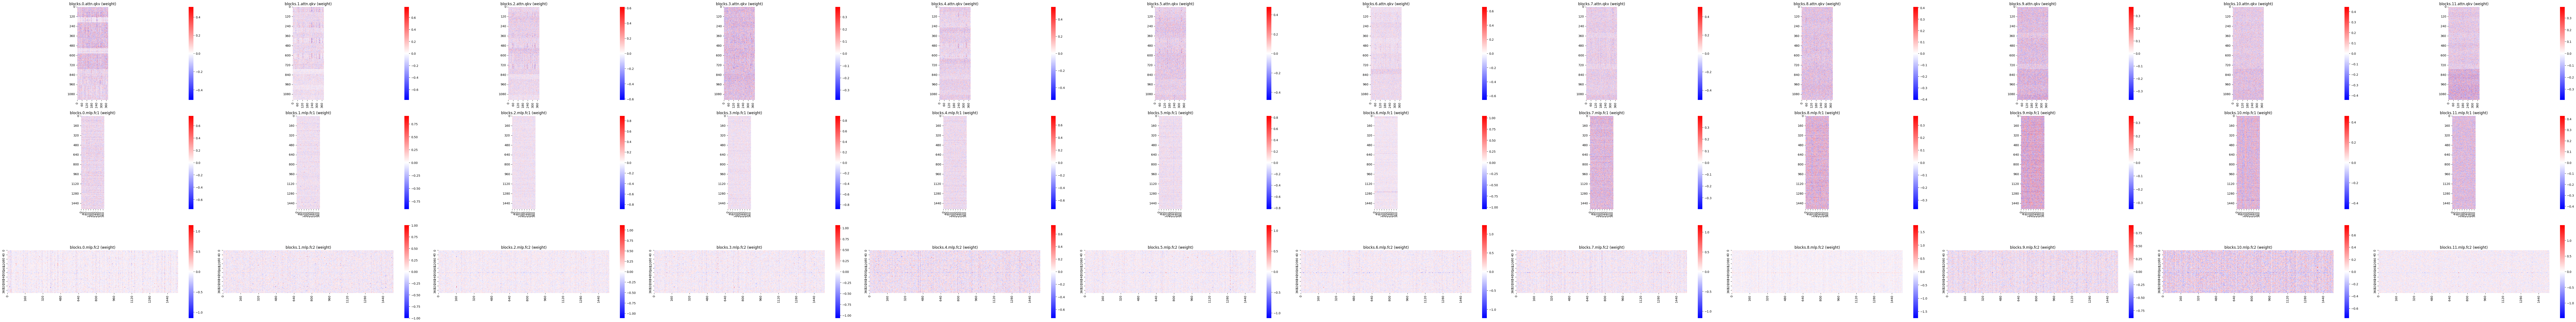

In [35]:
# get model's block_0 layers
sample_block = get_model_layers(model, match_names=[f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2'], match_types=['Linear'])

model_blocks_cnt = len(model.blocks)
block_layer_cnt = 3
layer_param_cnt = 1  # 2 for LRLinear

fig = plt.figure(figsize=(10*model_blocks_cnt, 5*block_layer_cnt*layer_param_cnt))
t = trange(model_blocks_cnt, desc='Blocks', leave=True)
for block_id in t:
    t.set_description(f'Block {block_id}')
    t.refresh()
    layers = get_model_layers(model, match_names=[f'blocks.{block_id}.attn.qkv', f'blocks.{block_id}.mlp.fc1', f'blocks.{block_id}.mlp.fc2'], match_types=['Linear'])   
    for layer_id, (label, layer) in enumerate(layers):
        layer_weights = get_layer_weights(layer, match_names=['weight'])
        for weight_id, (name, weight) in enumerate(layer_weights):
            # print(f'{label} ({name})')
            ax = fig.add_subplot(block_layer_cnt*layer_param_cnt, model_blocks_cnt, layer_id*layer_param_cnt*model_blocks_cnt+block_id+1 + weight_id*model_blocks_cnt)
            ax.set_title(f'{label} ({name})')

            # convert to numpy
            weight = weight.cpu().detach().numpy()

            # reduce resolution for large weights to speed up plotting
            kernel_size = round(max(weight.shape)/360)

            # plot heatmap
            abs_max = max(abs(weight.min()), abs(weight.max()))
            outlier_heatmap(weight, kernel_size=kernel_size, cmap='bwr', ax=ax, vmin=-abs_max, vmax=abs_max)
            plt.axis('scaled')

plt.tight_layout()
save_loc = f'{model_name}.png' if dir != None else f'{model_name}.png'
plt.savefig(save_loc)